# Topical Expert Model

In [1]:
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
import operator
import os
print(os.getcwd())
print(os.listdir('/Users/Brandon/Yelp Dataset/dataset'))
import json
import glob
from datetime import datetime
from pandas import HDFStore,DataFrame
import operator
import pylab as pl
import json

import matplotlib.pyplot as plt; plt.rcdefaults()
import matplotlib.pyplot as plt
import matplotlib

/Users/Brandon/Yelp Dataset/Yelp-FA17/local-elites/workspace
['.DS_Store', 'business.json', 'checkin.json', 'photos.json', 'review.json', 'review5000.json', 'tip.json', 'user.json', 'user5000.json']


In [2]:
#Copied from Kenta
def load_json_to_df(datapass):
    '''
    Load the json file and parse the file to pandas dataframe format
    
    Input:
        datapass(str) : directory to the json file
    Output:
        df(dataframe) : pandas dataframe object
    '''
    
    data = [] 
    with open(datapass) as data_file: 
        for f in data_file:
            data.append(json.loads(f))
    df = pd.DataFrame(data)
    return df

LOAD THE DATA

In [3]:
%%time
import_file = "/Users/Brandon/Yelp Dataset/dataset/review.json"
review = load_json_to_df(import_file)

CPU times: user 59.9 s, sys: 13.8 s, total: 1min 13s
Wall time: 1min 16s


In [4]:
%%time
import_file = "/Users/Brandon/Yelp Dataset/dataset/business.json"
business = load_json_to_df(import_file)

CPU times: user 4.93 s, sys: 212 ms, total: 5.14 s
Wall time: 5.21 s


In [5]:
%%time
import_file = "/Users/Brandon/Yelp Dataset/dataset/user.json"
user = load_json_to_df(import_file)

CPU times: user 53.8 s, sys: 11.7 s, total: 1min 5s
Wall time: 1min 16s


Sort by category

In [6]:
def categoryFind(df, cat):
    return [cat in i for i in df['categories']]

def category_counts(df):
    all_cats = []
    for i in df['categories']:
        for j in i:
            all_cats.append(j)
    categories = set(all_cats)
    category_counts = {}
    for cat in categories:
        category_counts[cat] = all_cats.count(cat)
    return len(categories), category_counts

def top_categories(counts, n):
    top_categories = sorted(counts.keys(), key=(lambda k: counts[k]),reverse=True)[:n]
    return top_categories

In [7]:
num_cats, cat_counts = category_counts(business)
top_cats = top_categories(cat_counts, 15)
display(top_cats)

['Restaurants',
 'Shopping',
 'Food',
 'Beauty & Spas',
 'Home Services',
 'Health & Medical',
 'Nightlife',
 'Bars',
 'Automotive',
 'Local Services',
 'Event Planning & Services',
 'Active Life',
 'Fashion',
 'Sandwiches',
 'Fast Food']

In [8]:
%%time
businessReviews = pd.merge(review, business,on='business_id',right_index=True,sort=False)[['business_id', 'cool', 'funny', 'review_id', 'stars_x', 'text', 'useful', 'user_id', 'categories', 'review_count', 'stars_y']]
bus_rev_users = pd.merge(businessReviews, user,on='user_id',right_index=True,sort=False)[['business_id', 'cool_x', 'funny_x', 'review_id', 'stars_x', 'text', 'useful_x', 'user_id', 'categories', 'stars_y', 'average_stars', 'cool_y', 'elite', 'fans', 'friends', 'name', 'review_count_y', 'yelping_since']]

CPU times: user 58.9 s, sys: 23.8 s, total: 1min 22s
Wall time: 1min 38s


In [9]:
%%time
businessReviews.info(memory_usage='deep')
#out = businessReviews.to_json(orient='records', lines=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4736897 entries, 0 to 4736896
Data columns (total 11 columns):
business_id     object
cool            int64
funny           int64
review_id       object
stars_x         int64
text            object
useful          int64
user_id         object
categories      object
review_count    int64
stars_y         float64
dtypes: float64(1), int64(5), object(5)
memory usage: 4.7 GB
CPU times: user 3.34 s, sys: 254 ms, total: 3.6 s
Wall time: 3.63 s


In [10]:
%%time
bus_rev_users.info(memory_usage='deep')
#with open(out, 'w') as f:
#    f.write(out)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4736897 entries, 0 to 4736896
Data columns (total 18 columns):
business_id       object
cool_x            int64
funny_x           int64
review_id         object
stars_x           int64
text              object
useful_x          int64
user_id           object
categories        object
stars_y           float64
average_stars     float64
cool_y            int64
elite             object
fans              int64
friends           object
name              object
review_count_y    int64
yelping_since     object
dtypes: float64(2), int64(7), object(9)
memory usage: 10.1 GB
CPU times: user 8.6 s, sys: 110 ms, total: 8.71 s
Wall time: 8.8 s


In [11]:
#with open('businessUsers.json', 'w') as f:
#    f.write(bus_rev_users.to_json(orient='records', lines=True))
for dtype in ['float','int','object']:
    selected_dtype = bus_rev_users.select_dtypes(include=[dtype])
    mean_usage_b = selected_dtype.memory_usage(deep=True).mean()
    mean_usage_mb = mean_usage_b / 1024 ** 2
    print("Average memory usage for {} columns: {:03.2f} MB".format(dtype,mean_usage_mb))

Average memory usage for float columns: 36.14 MB
Average memory usage for int columns: 36.14 MB
Average memory usage for object columns: 1002.14 MB


In [12]:
display(len(businessReviews))
display(len(bus_rev_users))
display(list(businessReviews))
display(list(bus_rev_users))

4736897

4736897

['business_id',
 'cool',
 'funny',
 'review_id',
 'stars_x',
 'text',
 'useful',
 'user_id',
 'categories',
 'review_count',
 'stars_y']

['business_id',
 'cool_x',
 'funny_x',
 'review_id',
 'stars_x',
 'text',
 'useful_x',
 'user_id',
 'categories',
 'stars_y',
 'average_stars',
 'cool_y',
 'elite',
 'fans',
 'friends',
 'name',
 'review_count_y',
 'yelping_since']

## Feature Extraction From Yelp Data

In [13]:
def category_choose(df, categories):
    cats = np.array([True] * len(df['categories']))
    for cat in categories:
        cats= cats & np.array(categoryFind(df,cat))
    return df[cats]

def numCategoryReviews(businessReviews):
    return businessReviews[['business_id','user_id']].groupby('user_id',as_index=False).count()

def average_star_category_rating(businessReviews):
    return businessReviews[['user_id','stars_x']].groupby('user_id',as_index=False).mean()

def std_star_category_rating(businessReviews):
    busRev = businessReviews[['user_id','stars_x']].groupby('user_id',as_index=False).agg(np.var)
    busRev['stars_x'] = busRev['stars_x'].pow(1./2)
    return busRev

def funny_useful_cool(businessReviews):
    return businessReviews[['user_id','funny','useful','cool']].groupby('user_id',as_index=False).sum()

def months_yelping(businessReviews):
    user_dates = businessReviews[['user_id','yelping_since']].drop_duplicates()
    curr_date = datetime(2017,10,17)
    uyelp_dates = [datetime.strptime(i, "%Y-%m-%d") for i in user_dates['yelping_since']]
    months_yelping = [(curr_date.year - i.year) * 12 + curr_date.month - i.month for i in uyelp_dates]
    user_dates['yelping_since'] = months_yelping
    return user_dates

def get_elite_users(df):
    temp = []
    for i in df['elite'].index.values:
        if df['elite'][i]:
            temp.append(i)
    return temp, df.loc[temp]

## Define the first feature model to be analyzed
Features: Total Reviews by User, Number of Category Reviews, Average Rating in Category, Std Dev of Ratings in Category, Funny, Useful, and Cool Votes, Number of Months since joining Yelp.

In [14]:
def feature1(df, df1, categories):
    if( not categories == "All"):
        df = category_choose(df, categories)
        df1 = category_choose(df1, categories)
    tot_reviews = df1[['user_id','review_count_y']]
    tot_reviews.columns = ['user_id','Total Reviews by User']
    catRev = numCategoryReviews(df)
    catRev.columns = ['user_id','Num Category Reviews']
    averageCat = average_star_category_rating(df)
    averageCat.columns = ['user_id','Average Rating in Category']
    stdCat = std_star_category_rating(df)
    stdCat.columns = ['user_id','Std Dev of Ratings in Category']
    fuc = funny_useful_cool(df)
    monthsYelp = months_yelping(df1)
    monthsYelp.columns = ['user_id', 'Months Yelping']
    is_elite = df1[['user_id','elite']]
    features = tot_reviews.merge(catRev,on='user_id').merge(averageCat,on='user_id').merge(stdCat,on='user_id').merge(fuc,on='user_id').merge(monthsYelp,on='user_id').merge(is_elite,on='user_id')
    features = features.drop_duplicates('user_id')
    features.index = range(len(features))
    elite_ind, elite_users = get_elite_users(features)
    expertClassifier = [0]*len(features)
    for i in elite_ind:
        expertClassifier[i]=1
    features = pd.concat([features, pd.DataFrame(expertClassifier,columns=['is_expert'])],axis=1)
    return features.fillna(0)

# Feature 2 has all of feature 1 plus the number of friends for each user
def feature2(df, df1, categories, features1 = pd.DataFrame()):
    if features1.empty:
        features1= feature1(df,df1,categories)
    
    friends = pd.DataFrame([len(i) for i in df1['friends']], columns = ['Num_Friends'])
    users = pd.DataFrame(df1['user_id'].values,columns=['user_id'])
    num_friends = pd.concat([users, friends],axis=1)
    features1= features1.merge(num_friends,on='user_id').drop_duplicates('user_id')
    features1.index = range(len(features1))
    return features1
    

In [104]:
%%time
# Lets do places with categories Restaurant
categories = ['Restaurants', 'Pizza']
feature_set_1 = feature1(businessReviews, bus_rev_users, categories)

CPU times: user 19.4 s, sys: 13.4 s, total: 32.8 s
Wall time: 44.3 s


In [106]:
feature_set_1

,user_id,Total Reviews by User,Num Category Reviews,Average Rating in Category,Std Dev of Ratings in Category,funny,useful,cool,Months Yelping,elite,is_expert
0,c5yp5hxwC1N98MjbV2LyWQ,84,1,4.000000,0.000000,0,0,1,76,[],0
1,eqWEgMH-DCP74i82BEAZzw,359,1,4.000000,0.000000,1,2,2,113,"[2010, 2014, 2011, 2015, 2016, 2012, 2013]",1
2,IpLZ7RevQrFPJWYc9Gxymg,97,1,3.000000,0.000000,0,1,1,68,"[2013, 2014]",1
3,WZXp9-V2dqRRJqhGgRqueA,327,5,3.800000,0.836660,4,5,5,61,"[2016, 2015]",1
4,XylT12exfdLiI_3uDLVIpw,344,6,2.166667,1.602082,1,4,0,84,[],0
5,Ji9PeffxjwqPLO7pEfSpKQ,93,9,3.222222,1.301708,6,14,10,107,"[2010, 2009]",1
6,TLIWzAJPrET0zX4_vgvLhg,53,4,3.000000,0.816497,0,1,0,38,[],0
7,E56sVQT5-OWfSejJrma8_w,13,1,5.000000,0.000000,0,0,0,68,[],0
8,P8mVj7AZwJTFFH5FXbbmUg,5,2,4.500000,0.707107,0,0,0,33,[],0
9,O7G_c6wFXSygr82qs0GAcA,18,2,3.000000,2.828427,0,1,1,32,[],0


In [107]:
feature_set_2 = feature2(businessReviews, bus_rev_users, categories, feature_set_1)
feature_set_2

,user_id,Total Reviews by User,Num Category Reviews,Average Rating in Category,Std Dev of Ratings in Category,funny,useful,cool,Months Yelping,elite,is_expert,Num_Friends
0,c5yp5hxwC1N98MjbV2LyWQ,84,1,4.000000,0.000000,0,0,1,76,[],0,6
1,eqWEgMH-DCP74i82BEAZzw,359,1,4.000000,0.000000,1,2,2,113,"[2010, 2014, 2011, 2015, 2016, 2012, 2013]",1,257
2,IpLZ7RevQrFPJWYc9Gxymg,97,1,3.000000,0.000000,0,1,1,68,"[2013, 2014]",1,15
3,WZXp9-V2dqRRJqhGgRqueA,327,5,3.800000,0.836660,4,5,5,61,"[2016, 2015]",1,181
4,XylT12exfdLiI_3uDLVIpw,344,6,2.166667,1.602082,1,4,0,84,[],0,762
5,Ji9PeffxjwqPLO7pEfSpKQ,93,9,3.222222,1.301708,6,14,10,107,"[2010, 2009]",1,53
6,TLIWzAJPrET0zX4_vgvLhg,53,4,3.000000,0.816497,0,1,0,38,[],0,19
7,E56sVQT5-OWfSejJrma8_w,13,1,5.000000,0.000000,0,0,0,68,[],0,19
8,P8mVj7AZwJTFFH5FXbbmUg,5,2,4.500000,0.707107,0,0,0,33,[],0,0
9,O7G_c6wFXSygr82qs0GAcA,18,2,3.000000,2.828427,0,1,1,32,[],0,8


In [108]:
display(len(feature_set_1))
display(feature_set_1.head(5))

166811

,user_id,Total Reviews by User,Num Category Reviews,Average Rating in Category,Std Dev of Ratings in Category,funny,useful,cool,Months Yelping,elite,is_expert
0,c5yp5hxwC1N98MjbV2LyWQ,84,1,4.000000,0.000000,0,0,1,76,[],0
1,eqWEgMH-DCP74i82BEAZzw,359,1,4.000000,0.000000,1,2,2,113,"[2010, 2014, 2011, 2015, 2016, 2012, 2013]",1
2,IpLZ7RevQrFPJWYc9Gxymg,97,1,3.000000,0.000000,0,1,1,68,"[2013, 2014]",1
3,WZXp9-V2dqRRJqhGgRqueA,327,5,3.800000,0.836660,4,5,5,61,"[2016, 2015]",1
4,XylT12exfdLiI_3uDLVIpw,344,6,2.166667,1.602082,1,4,0,84,[],0


## Classifier Setups (Sklearn Library)*

In [109]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn import tree

In [110]:
'''Runs the model specified by the clf (classifier), and features.
Features is assumed to have an 'is_expert' column which gives the classifications'''
def run_model(clf, features):
    train, test = train_test_split(X)
    train_classifier = train['is_expert'].values
    test_classifier = test['is_expert'].values
    train = train.drop('is_expert',axis=1)
    test = test.drop('is_expert', axis=1)
    clf.fit(train, train_classifier)
    rf_pred = clf.predict(test)
    model_perf= {'Model_Score' : clf.score(test, test_classifier),
                'Predictions' : rf_pred,
                'Actual' : test_classifier,
                'Prediction_Probabilities' : clf.predict_proba(test),
                'Total_Tested' : len(rf_pred),
                'Num_Experts_Predicted' : sum(rf_pred),
                'Num_Experts_Actual' : sum(test_classifier),
                'Num_Experts_Training' : sum(train_classifier)} 
    return model_perf

'''Runs the model n times, and prints out a dictionary with the statistics'''
def bootstrap_model(clf, features, n):
    models = []
    for i in range(1,n):
        models.append(run_model(clf, features))
    return models

'''Gets statistics from the bootstrap list of dictionaries'''
def boot_statistics(models):
    stats = []
    mean_model_score = np.mean([i['Model_Score'] for i in models])
    expert_pred_percentage = [i['Num_Experts_Predicted']/i['Num_Experts_Actual'] for i in models]
    mn = np.array((1.0 - np.array(mean_model_score))) * np.array(models[0]['Total_Tested'])
    stats = {'Mean_Wrong_Predictions' : round(mn),
             'Mean_Model_Score' : mean_model_score, 
             'Expert_Prediction_Percentage' : expert_pred_percentage}
    return stats

def graph_from_statistics(stats):
    return 0

 #### Drop unnessary columns from the features table (call it X).

In [111]:
X = feature_set_1.drop('user_id',axis=1).drop('elite',axis=1)
X2 = feature_set_2.drop('user_id',axis=1).drop('elite',axis=1)

## Run a random forest classifier

In [78]:
clf_RF = RandomForestClassifier(max_depth=3)

display(run_model(clf_RF,X))
display(run_model(clf_RF,X2))

RF_bootstrap = bootstrap_model(clf_RF, X, 10)
RF2_bootstrap = bootstrap_model(clf_RF, X2, 10)

{'Actual': array([0, 0, 0, ..., 0, 0, 0]),
 'Model_Score': 0.92186259399374149,
 'Num_Experts_Actual': 2937,
 'Num_Experts_Predicted': 2826,
 'Num_Experts_Training': 8987,
 'Prediction_Probabilities': array([[ 0.94951262,  0.05048738],
        [ 0.90339964,  0.09660036],
        [ 0.97790955,  0.02209045],
        ..., 
        [ 0.97145959,  0.02854041],
        [ 0.97145959,  0.02854041],
        [ 0.89693973,  0.10306027]]),
 'Predictions': array([0, 0, 0, ..., 0, 0, 0]),
 'Total_Tested': 21411}

{'Actual': array([0, 0, 0, ..., 0, 0, 0]),
 'Model_Score': 0.9029470832749521,
 'Num_Experts_Actual': 3016,
 'Num_Experts_Predicted': 1562,
 'Num_Experts_Training': 8908,
 'Prediction_Probabilities': array([[ 0.80920482,  0.19079518],
        [ 0.9740265 ,  0.0259735 ],
        [ 0.96543764,  0.03456236],
        ..., 
        [ 0.96282603,  0.03717397],
        [ 0.96543764,  0.03456236],
        [ 0.96543764,  0.03456236]]),
 'Predictions': array([0, 0, 0, ..., 0, 0, 0]),
 'Total_Tested': 21411}

## Run a gaussian naive bayes classifier

In [79]:
from sklearn.naive_bayes import GaussianNB
clf_NB = GaussianNB()

display(run_model(clf_NB,X))
display(run_model(clf_NB,X2))

NB_bootstrap = bootstrap_model(clf_NB, X, 10)
NB2_bootstrap = bootstrap_model(clf_NB, X2, 10)

{'Actual': array([0, 1, 1, ..., 0, 0, 0]),
 'Model_Score': 0.89449348465741907,
 'Num_Experts_Actual': 3038,
 'Num_Experts_Predicted': 1411,
 'Num_Experts_Training': 8886,
 'Prediction_Probabilities': array([[  9.99996976e-01,   3.02390484e-06],
        [  8.19422356e-03,   9.91805776e-01],
        [  9.99982971e-01,   1.70285354e-05],
        ..., 
        [  9.99998801e-01,   1.19871171e-06],
        [  9.99997997e-01,   2.00338432e-06],
        [  9.99999827e-01,   1.73446148e-07]]),
 'Predictions': array([0, 1, 0, ..., 0, 0, 0]),
 'Total_Tested': 21411}

{'Actual': array([0, 0, 0, ..., 0, 0, 0]),
 'Model_Score': 0.90089206482649109,
 'Num_Experts_Actual': 2904,
 'Num_Experts_Predicted': 1512,
 'Num_Experts_Training': 9020,
 'Prediction_Probabilities': array([[  9.99999918e-01,   8.16057384e-08],
        [  9.99999419e-01,   5.81100362e-07],
        [  9.99999827e-01,   1.72985600e-07],
        ..., 
        [  9.99976067e-01,   2.39327966e-05],
        [  9.99990879e-01,   9.12055039e-06],
        [  9.99994883e-01,   5.11650102e-06]]),
 'Predictions': array([0, 0, 0, ..., 0, 0, 0]),
 'Total_Tested': 21411}

## Run a decision tree classifier

In [80]:
clf_DT = tree.DecisionTreeClassifier()

display(run_model(clf_DT, X))
display(run_model(clf_DT, X2))

DT_bootstrap = bootstrap_model(clf_DT, X, 10)
DT2_bootstrap = bootstrap_model(clf_DT, X2, 10)

{'Actual': array([0, 0, 0, ..., 0, 1, 0]),
 'Model_Score': 0.89949091588435848,
 'Num_Experts_Actual': 2959,
 'Num_Experts_Predicted': 3075,
 'Num_Experts_Training': 8965,
 'Prediction_Probabilities': array([[ 1.,  0.],
        [ 1.,  0.],
        [ 1.,  0.],
        ..., 
        [ 0.,  1.],
        [ 0.,  1.],
        [ 1.,  0.]]),
 'Predictions': array([0, 0, 0, ..., 1, 1, 0]),
 'Total_Tested': 21411}

{'Actual': array([0, 0, 0, ..., 0, 0, 0]),
 'Model_Score': 0.9036943627107562,
 'Num_Experts_Actual': 2944,
 'Num_Experts_Predicted': 2966,
 'Num_Experts_Training': 8980,
 'Prediction_Probabilities': array([[ 1.,  0.],
        [ 1.,  0.],
        [ 1.,  0.],
        ..., 
        [ 1.,  0.],
        [ 1.,  0.],
        [ 1.,  0.]]),
 'Predictions': array([0, 0, 0, ..., 0, 0, 0]),
 'Total_Tested': 21411}

In [81]:
DT_stats = boot_statistics(DT_bootstrap)
NB_stats = boot_statistics(NB_bootstrap)
RF_stats = boot_statistics(RF_bootstrap)
#
DT2_stats = boot_statistics(DT2_bootstrap)
NB2_stats = boot_statistics(NB2_bootstrap)
RF2_stats = boot_statistics(RF2_bootstrap)

display(DT_stats, DT2_stats)
display(NB_stats, DT2_stats)
display(RF_stats, RF2_stats)
y = [DT_stats['Mean_Model_Score'],NB_stats['Mean_Model_Score'],RF_stats['Mean_Model_Score']]
N = len(y)
x = range(N)
width = 1/1.5
plt.bar(x, y, width)

fig = plt.gcf()

{'Expert_Prediction_Percentage': [1.0056685561853951,
  1.0056572379367721,
  1.0279959030385797,
  1.0232245035341636,
  1.0265635507733692,
  1.0318752119362495,
  1.0083979328165376,
  1.0314933965458855,
  0.98185417354008575],
 'Mean_Model_Score': 0.90047690958437776,
 'Mean_Wrong_Predictions': 2131.0}

{'Expert_Prediction_Percentage': [0.9934683213585892,
  0.98454820288881428,
  0.98852514343570708,
  1.0325285043594903,
  0.99554946935980826,
  1.0170590242238144,
  0.97698125616573495,
  1.0438744515693554,
  0.98686371100164205],
 'Mean_Model_Score': 0.90082979154017395,
 'Mean_Wrong_Predictions': 2123.0}

{'Expert_Prediction_Percentage': [0.47124433600557686,
  0.49770642201834864,
  0.51197113807805839,
  0.48001366586949096,
  0.5001660577881103,
  0.49950445986124875,
  0.51721854304635762,
  0.49343401181877872,
  0.48971466489714666],
 'Mean_Model_Score': 0.89887337246171484,
 'Mean_Wrong_Predictions': 2165.0}

{'Expert_Prediction_Percentage': [0.9934683213585892,
  0.98454820288881428,
  0.98852514343570708,
  1.0325285043594903,
  0.99554946935980826,
  1.0170590242238144,
  0.97698125616573495,
  1.0438744515693554,
  0.98686371100164205],
 'Mean_Model_Score': 0.90082979154017395,
 'Mean_Wrong_Predictions': 2123.0}

{'Expert_Prediction_Percentage': [0.6293132900580799,
  0.36620185922974768,
  0.71660466689212043,
  0.53044925124792008,
  0.58117326057298768,
  0.70189431704885341,
  0.46985094850948511,
  0.43246037215713301,
  0.34394904458598724],
 'Mean_Model_Score': 0.90565078178921532,
 'Mean_Wrong_Predictions': 2020.0}

{'Expert_Prediction_Percentage': [0.64422753281723322,
  0.37391882900864937,
  0.34879032258064518,
  0.42293423271500841,
  0.95035924232527758,
  0.60919154646091911,
  0.54223433242506813,
  0.39993261455525608,
  0.51162018592297476],
 'Mean_Model_Score': 0.90346083788706744,
 'Mean_Wrong_Predictions': 2067.0}

# Unsupervised Learning
## Kmeans Cluster

In [112]:
'''Runs the model specified by the clf (classifier), and features.
Features is assumed to have an 'is_expert' column which gives comparisons to unsupervised learning'''
def run_unsup_model(clf, features):
    train = features.drop('is_expert',axis=1)
    clf.fit(train)
    rf_pred = clf.predict(train)
    model_perf= {'Model_Score' : clf.score(train),
                'Predictions' : rf_pred,
                'Total_Tested' : len(rf_pred),
                'Num_Experts_Predicted' : sum(rf_pred),
                'Num_Non_Experts' : sum(1-rf_pred),
                'Cluster_Centers' : clf.cluster_centers_,
                'Cluster_Points' : clf.transform(train)} 
    return model_perf

def graph_clusters(model):
    x = model['Cluster_Points'][:,0]
    y = model['Cluster_Points'][:,1]
    labels = model['Predictions']
    plt.scatter(x, y, c=[matplotlib.cm.spectral(float(i) /10) for i in labels]);   
    plt.show()

def add_pred_column(model, features):
    return features.assign(preds=pd.Series(model['Predictions']).values)

def unsup_statistics(model, features):
    features = add_pred_column(model, features)
    return {'Num_Experts' : sum(features.is_expert),
            'Num_Experts_Predicted' : sum(features.preds),
            'Intersection' : sum(features.is_expert & features.preds)}

In [113]:
from sklearn.cluster import KMeans
clf_KMeans = KMeans(n_clusters=2)
#display(clf_KMeans.labels_)

#kmeans_predictions = clf_KMeans.predict(X2)
#display(sum(clf_KMeans.predict(X2)))
#display(sum(1 - clf_KMeans.predict(X2)))
#display(clf_KMeans.cluster_centers_)

#clf_kmeans_2d = clf_KMeans.transform(X2)

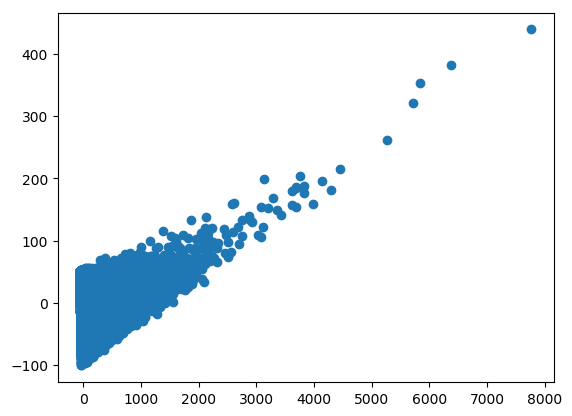

In [114]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2).fit(X)
pca_2d = pca.transform(X)
pca_x = pca_2d[:,0]
pca_y = pca_2d[:,1]
pl.scatter(pca_x, pca_y)
plt.show()


In [115]:
model_test = run_unsup_model(clf_KMeans,X)

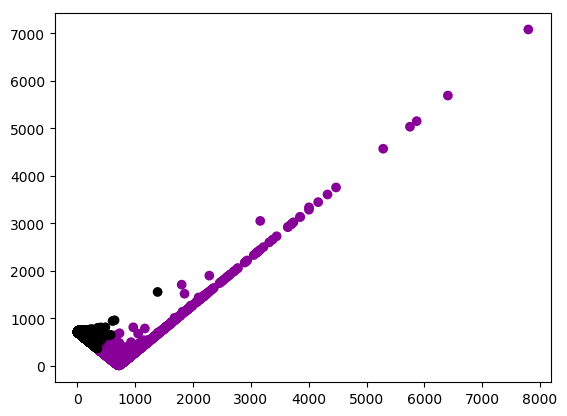

In [116]:
graph_clusters(model_test)

In [117]:
display(unsup_statistics(model_test, X))

{'Intersection': 3295, 'Num_Experts': 17405, 'Num_Experts_Predicted': 3643}

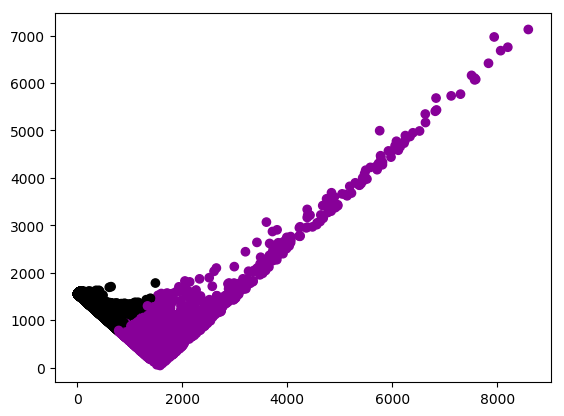

{'Intersection': 1458, 'Num_Experts': 17405, 'Num_Experts_Predicted': 1625}

In [118]:
model2_test = run_unsup_model(clf_KMeans, X2)
cluster2_plot = graph_clusters(model2_test)
display(unsup_statistics(model2_test, X2))

In [119]:
add_pred_column(model_test, X)

,Total Reviews by User,Num Category Reviews,Average Rating in Category,Std Dev of Ratings in Category,funny,useful,cool,Months Yelping,is_expert,preds
0,84,1,4.000000,0.000000,0,0,1,76,0,0
1,359,1,4.000000,0.000000,1,2,2,113,1,0
2,97,1,3.000000,0.000000,0,1,1,68,1,0
3,327,5,3.800000,0.836660,4,5,5,61,1,0
4,344,6,2.166667,1.602082,1,4,0,84,0,0
5,93,9,3.222222,1.301708,6,14,10,107,1,0
6,53,4,3.000000,0.816497,0,1,0,38,0,0
7,13,1,5.000000,0.000000,0,0,0,68,0,0
8,5,2,4.500000,0.707107,0,0,0,33,0,0
9,18,2,3.000000,2.828427,0,1,1,32,0,0


In [120]:
X2_pred = add_pred_column(model2_test,X2)

In [121]:
X2[X2_pred['preds']==True]

,Total Reviews by User,Num Category Reviews,Average Rating in Category,Std Dev of Ratings in Category,funny,useful,cool,Months Yelping,is_expert,Num_Friends
4,344,6,2.166667,1.602082,1,4,0,84,0,762
10,1039,32,3.750000,0.762001,11,39,15,100,1,868
38,713,41,3.390244,1.021715,150,250,177,124,1,1193
82,1952,55,3.436364,1.084634,36,91,52,118,1,621
92,891,14,4.071429,1.071612,34,80,55,88,1,2932
115,592,4,3.750000,0.957427,1,9,5,109,1,1521
140,946,14,3.285714,0.825420,23,24,14,100,1,493
143,5778,60,3.283333,0.523731,84,158,108,95,1,497
152,1340,1,5.000000,0.000000,0,4,2,107,1,849
153,1138,2,4.000000,1.414214,0,0,0,80,1,362


In [122]:
my = X2['Months Yelping']>12
trbu = X2['Total Reviews by User']>10
ncr = X2['Num Category Reviews']>5
fuc = X2['funny'] + X2['useful'] + X2['cool'] > 15
nf = X2['Num_Friends']>10
list(X2)
sum(my & trbu & ncr & fuc & nf)


2088